<a href="https://colab.research.google.com/github/100jy/dacon_workout/blob/main/%EB%8D%B0%EC%9D%B4%EC%BD%98_%EC%9A%B4%EB%8F%99%EB%8F%99%EC%9E%91_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO
- Conv1D 기반
- 딥러닝 위해서는 aug 필요
- random chunking(500 range), random scaling(1~0.9)
- random stretch 추가(빠르게 하거나 느리게 하거나)




# import modules

In [386]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [387]:
!pip install pytorch-lightning

In [388]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import pandas as pd
import numpy as np
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
os.chdir('/content/drive/MyDrive/데이콘')

In [389]:
train_df=pd.read_csv('train_features.csv')
train_labels_df=pd.read_csv('train_labels.csv')
test=pd.read_csv('test_features.csv')
submission=pd.read_csv('sample_submission.csv')
train_labels_df['label'].astype('category')
train_labels_df = pd.get_dummies(train_labels_df)

train_val = train_df.values.reshape(-1,600,8)
msk = np.random.rand(len(train_val)) < 0.9

train, train_labels = train_val[msk], train_labels_df[msk]
val, val_labels = train_val[~msk], train_labels_df[~msk]

# EDA

In [21]:
train_df

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


In [ ]:
def normalizing(x):
  mu = x.mean()
  std = x.std()
  return (x-mu) / std

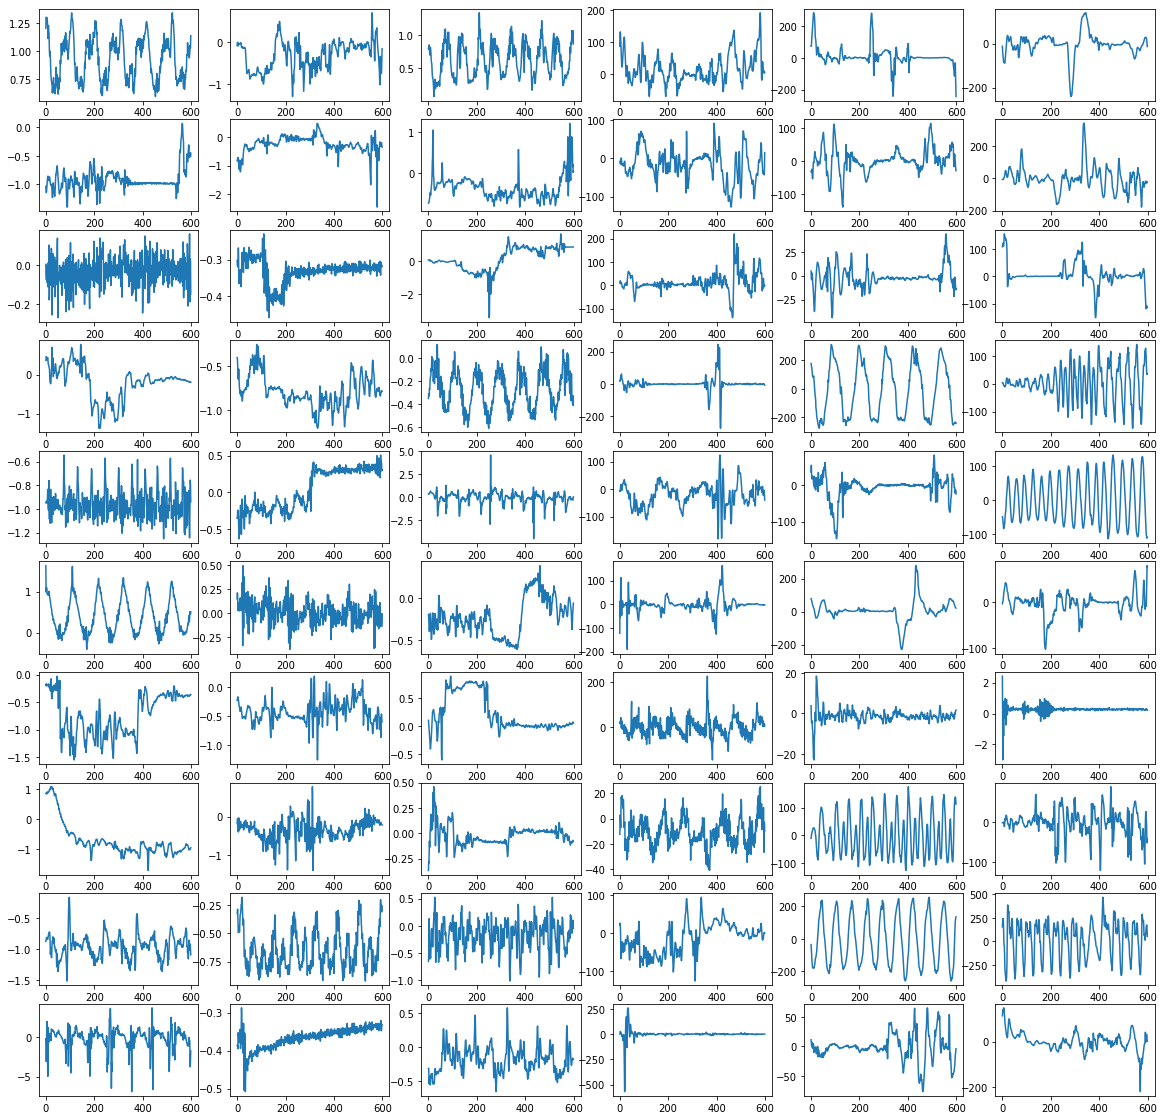

In [35]:
n_rows = 10
n_cols = 6

plt.figure(figsize=(20,20))
for row in range(n_rows):
  for col in range(n_cols):
    index = n_cols * row + col
    plt.subplot(n_rows, n_cols, index + 1)
    plt.plot(train_df.iloc[index*600:(index+1)*600,col+2].values)
plt.show()

# Dataloader

In [420]:
class DatasetSignals(Dataset):
  def __init__(self, df=train, label_df=train_labels, device='cuda', validation=False, random_factor=None):
    super(DatasetSignals, self).__init__()
    #scaling 
    max_val = ((df[:,:,2:]).max(axis=0, keepdims=True).max(axis=1, keepdims=True))
    signals =  (df[:,:,2:])/max_val
    self.device = device
    self.validation = validation

    self.scaling_lower_bound = random_factor.get('scaling_lower_bound')
    self.chunk_len = random_factor.get('chunk_len')
    self.stretch_lower_bound = random_factor.get('stretch_lower_bound')
    self.stretch_upper_bound = random_factor.get('stretch_upper_bound')

    #make cache
    self.signal = torch.tensor(signals, dtype=torch.float32)
    self.label = torch.tensor(label_df.iloc[:,2:].values, dtype=torch.long, device=device)

  def __len__(self):
    return len(self.label)
  
  def __getitem__(self, idx):
    seq_len = 600
    chunk_len = self.chunk_len
    x = torch.zeros(chunk_len,6, dtype=torch.float32, device=self.device)
    
    if self.validation:
      start_point = 0
      scale_factor = 1
      x[:,:] = scale_factor * self.signal[idx, start_point:start_point+chunk_len, :]
    
    else:
      start_point = np.random.randint(seq_len-chunk_len)
      
      # random scaling(lower_bound~1)
      lower_bound = self.scaling_lower_bound
      scale_factor = (1-lower_bound)*torch.rand(1) + lower_bound
      
      # random stretch
      lower_bound = self.stretch_lower_bound
      upper_bound = self.stretch_upper_bound
      stretch_factor =  (upper_bound-lower_bound)*torch.rand(1) + lower_bound
      new_len = int(seq_len * stretch_factor)
      # slow
      if stretch_factor<1:
        cut_len = (seq_len - new_len)//2 + 1
        new_signal =  self.signal[[idx], cut_len:-cut_len, :] 
        new_signal = F.interpolate(new_signal.transpose(-1,-2), size=seq_len).squeeze(0).transpose(-1,-2)
      # faster
      else:
        new_signal = F.interpolate(self.signal[[idx], :, :] .transpose(-1,-2), size=new_len).squeeze(0).transpose(-1,-2)
      
      # random chunking
      x[:,:] = scale_factor * new_signal[start_point:start_point+chunk_len, :]
        
    # 400,6
    return x, self.label[idx,:]

In [417]:
config = {'scaling_lower_bound':0.9,
                 'chunk_len':500,
             'stretch_lower_bound':0.9,
             'stretch_upper_bound':1.1,}
             
dataset = DatasetSignals(random_factor=config)

(torch.Size([500, 6]), torch.Size([61]))

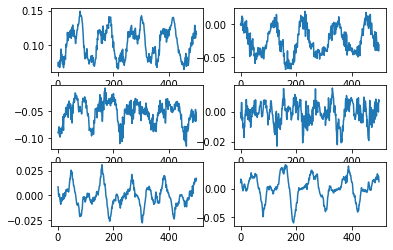

In [418]:
value = dataset.__getitem__(0)[0].detach().cpu().numpy()

n_rows=3
n_cols=2
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.plot((value[...,index]))

dataset.__getitem__(0)[0].shape, dataset.__getitem__(0)[1].shape

#Model

In [336]:
# B 500 1 (float32)
class MultiConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(MultiConv, self).__init__()
        self.conv_4 = nn.Sequential(nn.Conv1d(in_ch, out_ch, 4, 2, padding=1), nn.ReLU())
        self.conv_6 = nn.Sequential(nn.Conv1d(in_ch, out_ch, 6, 2, padding=2), nn.ReLU())
        self.conv_8 = nn.Sequential(nn.Conv1d(in_ch, out_ch, 8, 2, padding=3), nn.ReLU())
        self.conv_10 = nn.Sequential(nn.Conv1d(in_ch, out_ch, 10, 2, padding=4), nn.ReLU())
        
        self.transition = nn.Sequential(nn.Conv1d(4*out_ch, out_ch, 1, 1), nn.ReLU())    

    def forward(self, x):
        x_1 = self.conv_4(x)
        x_2 = self.conv_6(x)
        x_3 = self.conv_8(x)
        x_4 = self.conv_10(x)
        # B 3*ch l
        #print(x_1.size(), x_2.size(), x_3.size())
        x = torch.cat((x_1,x_2,x_3,x_4), dim=1)
        x = self.transition(x)
        return x_1



class ConvNet(nn.Module):
    def __init__(self,config):
        super(ConvNet, self).__init__()
        input_len = config.get('chunk_len')
        self.out_len = input_len//(2**5)
        self.conv = nn.Sequential(MultiConv(1, 64), nn.ReLU(),                         
                                  MultiConv(64, 128), nn.ReLU(),
                                  MultiConv(128, 256), nn.ReLU(),
                                 MultiConv(256, 512), nn.ReLU(),
                                  nn.Dropout(0.1),
                                  MultiConv(512, 512), nn.ReLU()
                                  nn.Dropout(0.1),
                                  )
        
        self.fc = nn.Linear(self.out_len*512, 61)                               

    def forward(self, x):
        x = self.conv(x.transpose(-1,-2))
        #print(x.size(), self.out_len)
        x = self.fc(x.view(x.shape[0],-1))
        return x


# 변수별로 독립 seq로 regression
class ParallelConv(nn.Module):
  def __init__(self, config):
    super(ParallelConv, self).__init__()

    self.feature_1 = ConvNet(config)
    self.feature_2 = ConvNet(config)
    self.feature_3 = ConvNet(config)
    self.feature_4 = ConvNet(config)
    self.feature_5 = ConvNet(config)
    self.feature_6 = ConvNet(config)

    self.last = nn.Linear(61*6,61)
  
  def forward(self, x_time):
    
    seq_1 = self.feature_1(x_time[:,:,[0]])
    seq_2 = self.feature_2(x_time[:,:,[1]])
    seq_3 = self.feature_3(x_time[:,:,[2]])
    seq_4 = self.feature_4(x_time[:,:,[3]])
    seq_5 = self.feature_5(x_time[:,:,[4]])
    seq_6 = self.feature_6(x_time[:,:,[5]])
    
    #B 61 6
    out = torch.cat([seq_1, seq_2, seq_3, seq_4, seq_5, seq_6], dim=-1)
    out = self.last(out)

    # B 61
    return F.softmax(out.squeeze(-1))

In [424]:
# B 500 1 (float32)
class MultiConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(MultiConv, self).__init__()
        self.conv_4 = nn.Sequential(nn.Conv1d(in_ch, out_ch, 4, 2, padding=1), nn.ReLU())
        self.conv_6 = nn.Sequential(nn.Conv1d(in_ch, out_ch, 6, 2, padding=2), nn.ReLU())
        self.conv_8 = nn.Sequential(nn.Conv1d(in_ch, out_ch, 8, 2, padding=3), nn.ReLU())
        self.conv_10 = nn.Sequential(nn.Conv1d(in_ch, out_ch, 10, 2, padding=4), nn.ReLU())
        
        self.transition = nn.Sequential(nn.Conv1d(4*out_ch, out_ch, 1, 1), nn.ReLU())    

    def forward(self, x):
        x_1 = self.conv_4(x)
        x_2 = self.conv_6(x)
        x_3 = self.conv_8(x)
        x_4 = self.conv_10(x)
        # B 3*ch l
        #print(x_1.size(), x_2.size(), x_3.size())
        x = torch.cat((x_1,x_2,x_3,x_4), dim=1)
        x = self.transition(x)
        return x_1



class ConvNet(nn.Module):
    def __init__(self,config):
        super(ConvNet, self).__init__()
        input_len = config.get('chunk_len')
        self.out_len = input_len//(2**5)
        self.LSTM = nn.LSTM(input_len, input_len)
        self.conv = nn.Sequential(MultiConv(1, 64), nn.ReLU(),                         
                                  MultiConv(64, 128), nn.ReLU(),
                                  MultiConv(128, 256), nn.ReLU(),
                                 MultiConv(256, 512), nn.ReLU(),
                                  MultiConv(512, 512), nn.ReLU()
                                  )
        
        self.fc = nn.Linear(self.out_len*512, 61)                               

    def forward(self, x):
        re,_ = self.LSTM(x.transpose(-1,-2))
        add = re+x.transpose(-1,-2)
        x = self.conv(add)
        #print(x.size(), self.out_len)
        x = self.fc(x.view(x.shape[0],-1))
        x = F.dropout(x, p=0.3)
        return x + re[...,-61:].squeeze(1)


# 변수별로 독립 seq로 regression
class ParallelConv(nn.Module):
  def __init__(self, config):
    super(ParallelConv, self).__init__()

    self.feature_1 = ConvNet(config)
    self.feature_2 = ConvNet(config)
    self.feature_3 = ConvNet(config)
    self.feature_4 = ConvNet(config)
    self.feature_5 = ConvNet(config)
    self.feature_6 = ConvNet(config)

    self.last = nn.Linear(61*6,61)
  
  def forward(self, x_time):
    
    seq_1 = self.feature_1(x_time[:,:,[0]])
    seq_2 = self.feature_2(x_time[:,:,[1]])
    seq_3 = self.feature_3(x_time[:,:,[2]])
    seq_4 = self.feature_4(x_time[:,:,[3]])
    seq_5 = self.feature_5(x_time[:,:,[4]])
    seq_6 = self.feature_6(x_time[:,:,[5]])
    
    #B 61 6
    out = torch.cat([seq_1, seq_2, seq_3, seq_4, seq_5, seq_6], dim=-1)
    out = self.last(out)

    # B 61
    return F.softmax(out.squeeze(-1))

# lightning wrapper

In [308]:
class Model(pl.LightningModule):

    def __init__(self, config):
        super().__init__()
        self.model = ParallelConv(config)

    @staticmethod
    def cce_loss(pred_label, target_label):
      return -(((pred_label+1e-5).log() * target_label).sum(dim=1)).mean()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        pred_label = self.model(x)
        loss = self.cce_loss(pred_label, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
      x, y = val_batch
      pred_label = self.model(x)

      loss = self.cce_loss(pred_label, y)
      return {'val_loss': loss}
    
    def validation_epoch_end(self, outputs):
      avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
      tensorboard_logs = {'val_loss': avg_loss}
      print(f"Epoch {self.current_epoch} | val_loss:{avg_loss}")
      return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3)
        return optimizer

# fitting

In [ ]:
config = {'scaling_lower_bound':0.9,
          'stretch_lower_bound':0.8,
          'stretch_upper_bound':1.2,
          'chunk_len':500,}
train_data = DatasetSignals(train, train_labels, random_factor=config)
val_data = DatasetSignals(val, val_labels, validation=True, random_factor=config)
model = Model(config).cuda()
trainer = pl.Trainer(progress_bar_refresh_rate=40, gpus=1, max_epochs=50)
trainer.fit(model, DataLoader(train_data, batch_size=4, shuffle=True), DataLoader(val_data, batch_size=4))

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | ParallelConv | 102 M 
---------------------------------------
102 M     Trainable params
0         Non-trainable params
102 M     Total params


Epoch 0 | loss:4.083204746246338


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


Epoch 0 | loss:2.36331844329834


Epoch 1 | loss:2.0973498821258545


Epoch 2 | loss:1.9869798421859741


Epoch 3 | loss:1.8394962549209595


Epoch 4 | loss:1.7388986349105835
